In [18]:
#imports
import numpy as np
from glob import glob
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib 
matplotlib.use('agg')
import matplotlib.pyplot as plt                        
%matplotlib inline
import os
import datetime
import time
from PIL import ImageFile
from sklearn.metrics import classification_report
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore")
import pylab as pl


In [19]:
def trainData(input_size,step_size,n_points=1000):
    ### create multi class dataset
    np.random.seed(42)
    X=np.random.random((n_points,input_size))
    #x=np.zeros((n_points,input_size))
    X=np.float32(X)
    Y = np.zeros((n_points,1))
    dist=np.sqrt(np.sum(np.power(X-0.5,2),axis=1))
    dist.reshape(n_points,1)
    Y=np.int64(dist/step_size)
    Y=np.reshape(Y,(n_points,1))
    ### split into train, valid, and test
    split1 = int(0.75*n_points)
    split2 = int(0.95*n_points)
    X_train = X[0:split1,:]
    X_valid  = X[split1:split2,:]
    X_test  = X[split2:,:]
    y_train = Y[0:split1]
    y_valid  = Y[split1:split2]
    y_test  = Y[split2:]
    output_classes=np.max(Y)+1
    
    return X_train, y_train, X_valid, y_valid,X_test, y_test, output_classes


In [20]:
#model parameters
input_size=2
features_train, labels_train, features_valid,\
labels_valid,features_test, labels_test, classes = trainData(input_size,0.2,10000)
output_classes=classes
hidden_layers=3
hidden_layers_size=[100,200,50]
activation=['ReLU','ReLU','ReLU']
dropout=[0.2,0.0,0.0]
retrain=False
learning_rate=0.0001
# enter model path and file name where you want to load or save your new model
model_path="model.pth"

In [21]:
def visualize_classifier(model, X_test, y_test,device,classes):
    colors=['b','r','g','y','k']
    model.eval()
    with torch.no_grad():
        x_min = 0.0; x_max = 1.0
        y_min = 0.0; y_max = 1.0
        h = .01  # step size in the mesh
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        model_input=np.c_[xx.ravel(), yy.ravel()]
        model_input=torch.from_numpy(model_input)
        model_input=model_input.float()
        Z = model.forward(model_input.to(device))
        ps = torch.exp(Z)
        top_p, top_class = ps.topk(1, dim=1)
        nZ=top_class.cpu()
        nZ=nZ.data.numpy()
        nZ = nZ.reshape(xx.shape)
        np.int32(nZ)
        plt.figure(figsize=(8,8))
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        nZ=nZ.tolist()
        plt.pcolormesh(xx, yy, nZ,cmap=pl.cm.seismic)

        # Plot also the test points
        for i in range(0,classes):
            index=y_test==i
            index=index.reshape(y_test.shape[0])
            #print(index)
            x=X_test[index,0]
            y=X_test[index,1]
            plt.scatter(x, y, color = colors[i%5], label=str(i))
        plt.legend()
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.show()
        plt.savefig("performance.png")


In [22]:
def create_MLP(input_s,output_s,hidden_layers,hidden_size,activation,dropout):
    ml=[]
    layers=[input_s]+hidden_size+[output_s]
    dropout=[0.0]+dropout+[0.0]
    activation=['']+activation+['']
    for i in range(1,len(layers)):
        ml.append(nn.Linear(layers[i-1],layers[i]))
        if(activation[i]!=''):
            ml.append(eval('nn.'+activation[i]+'()'))
        if(dropout[i-1]>0):
            ml.append(nn.Dropout(dropout[i-1]))
    ml.append(nn.LogSoftmax())
    model=nn.Sequential(*tuple(ml))
    return model

In [23]:
def test_model(model,loader,criterion, device):
    test_count=0.0
    test_size=0
    test_loss = 0.0
    test_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            #print(inputs)
            #print(inputs.dtype)
            #print(labels.dtype)
            labels=labels.long()
            #print(labels.dtype)
            inputs, labels = inputs.to(device), labels.to(device)
            test_size+=len(labels)
            #print(inputs)
            logps = model.forward(inputs)
            #print(logps.dtype)
            #batch_loss = criterion(logps, labels)
            batch_loss = criterion(logps, torch.max(labels, 1)[0])
            test_loss += batch_loss.item()
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            #test_accuracy += torch.mean(equals.type(torch.FloatTensor))
            test_count+=torch.sum(equals.type(torch.FloatTensor))
        #test_accuracy=test_accuracy/len(loader)
        test_accuracy=test_count/test_size
        test_loss=test_loss/len(loader)
    return test_accuracy,test_loss,test_count

In [24]:
def test_report_model(model, loader,device):
    test_count=0.0
    test_size=0
    test_accuracy = 0.0
    predictions=[]
    true_labels=[]
    model.eval()
    with torch.no_grad():
        for inputs,labels in loader:
            test_size+=len(inputs)
            inputs=inputs.to(device)
            labels=labels.to(device)
            Z = model.forward(inputs)
            ps = torch.exp(Z)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_count+=torch.sum(equals.type(torch.FloatTensor))
            true_labels+=(labels.squeeze().tolist())
            predictions+=(top_class.squeeze().tolist())
        test_accuracy=test_count/test_size
        print(classification_report(true_labels, predictions))
            
    return test_accuracy,test_count

In [25]:
def train_model(model,epochs, trainloader,validloader, optimizer, criterion,\
                device, model_path_name,valid_count_max):

    start=time.time()
    print (datetime.datetime.now())
    steps = 0
    print_every = 20
    for epoch in range(epochs):
        step=0
        train_loss = 0.0
        train_accuracy=0.0
        model.train()
        for inputs, labels in trainloader:
            step += 1
            if(step%print_every==0):
                print(f"Epoch {epoch+1}/{epochs}..step {step}/{len(trainloader)}.."
                      f"time so far {(time.time()-start)/60:.3f} mins")
            labels=labels.long()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, torch.max(labels, 1)[0])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_accuracy=train_accuracy/len(trainloader)
        train_loss=train_loss/len(trainloader)
        valid_accuracy, valid_loss,valid_count=test_model(model,validloader,criterion,device)
        print (datetime.datetime.now())
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train accuracy: {train_accuracy:.5f}.."
              f"Train loss: {train_loss:.3f}.. "
              f"Valid loss: {valid_loss:.3f}.. "
              f"Valid accuracy: {valid_accuracy:.5f}.."
              f"Time Elspased so far: {time.time()-start:.3f} seconds")
        train_loss = 0
        train_accuracy=0
        if valid_count>valid_count_max:
            print(f"*************New Model Saved with correct predictions of:{valid_count:.5f}***************")
            torch.save(model, model_path_name)
            valid_count_max= valid_count
    return model,valid_count_max

In [26]:
# Model instainstiation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(retrain):
    model = torch.load(model_path)
else:
    model=create_MLP(2,output_classes,hidden_layers,hidden_layers_size,activation,dropout)
    

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.to(device);

In [27]:
print(device)
print(model)

cuda
Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=200, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.2)
  (5): Linear(in_features=200, out_features=50, bias=True)
  (6): ReLU()
  (7): Linear(in_features=50, out_features=4, bias=True)
  (8): LogSoftmax()
)


In [28]:
#create dataset loaders

inputs_train=torch.from_numpy(features_train)
outputs_train=torch.from_numpy(labels_train)

inputs_valid=torch.from_numpy(features_valid)
outputs_valid=torch.from_numpy(labels_valid)

inputs_test=torch.from_numpy(features_test)
outputs_test=torch.from_numpy(labels_test)

train_data=torch.utils.data.TensorDataset(inputs_train, outputs_train)
valid_data=torch.utils.data.TensorDataset(inputs_valid, outputs_valid)
test_data=torch.utils.data.TensorDataset(inputs_test, outputs_test)

# loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=250, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [29]:
# test model intially over validation set
valid_acc_max,valid_loss,valid_count_max=test_model(model,validloader,criterion,device)

In [30]:
#train model
model,valid_count_max = train_model(model,500, trainloader,validloader, optimizer,criterion,device,model_path,valid_count_max) 
print(valid_count_max)


2019-03-15 15:44:51.167187
Epoch 1/500..step 20/30..time so far 0.002 mins
2019-03-15 15:44:51.344565
Epoch 1/500.. Train accuracy: 0.38133..Train loss: 1.356.. Valid loss: 1.333.. Valid accuracy: 0.37350..Time Elspased so far: 0.178 seconds
Epoch 2/500..step 20/30..time so far 0.004 mins
2019-03-15 15:44:51.488278
Epoch 2/500.. Train accuracy: 0.38347..Train loss: 1.305.. Valid loss: 1.271.. Valid accuracy: 0.37350..Time Elspased so far: 0.321 seconds
Epoch 3/500..step 20/30..time so far 0.006 mins
2019-03-15 15:44:51.620703
Epoch 3/500.. Train accuracy: 0.43973..Train loss: 1.238.. Valid loss: 1.204.. Valid accuracy: 0.44600..Time Elspased so far: 0.454 seconds
*************New Model Saved with correct predictions of:892.00000***************
Epoch 4/500..step 20/30..time so far 0.010 mins
2019-03-15 15:44:51.827284
Epoch 4/500.. Train accuracy: 0.43973..Train loss: 1.181.. Valid loss: 1.159.. Valid accuracy: 0.44600..Time Elspased so far: 0.660 seconds
Epoch 5/500..step 20/30..time s

Epoch 33/500..step 20/30..time so far 0.085 mins
2019-03-15 15:44:56.327144
Epoch 33/500.. Train accuracy: 0.86040..Train loss: 0.428.. Valid loss: 0.391.. Valid accuracy: 0.90400..Time Elspased so far: 5.160 seconds
*************New Model Saved with correct predictions of:1808.00000***************
Epoch 34/500..step 20/30..time so far 0.087 mins
2019-03-15 15:44:56.498076
Epoch 34/500.. Train accuracy: 0.86867..Train loss: 0.408.. Valid loss: 0.372.. Valid accuracy: 0.90750..Time Elspased so far: 5.331 seconds
*************New Model Saved with correct predictions of:1815.00000***************
Epoch 35/500..step 20/30..time so far 0.090 mins
2019-03-15 15:44:56.661157
Epoch 35/500.. Train accuracy: 0.86707..Train loss: 0.389.. Valid loss: 0.355.. Valid accuracy: 0.90750..Time Elspased so far: 5.494 seconds
Epoch 36/500..step 20/30..time so far 0.093 mins
2019-03-15 15:44:56.822628
Epoch 36/500.. Train accuracy: 0.87573..Train loss: 0.375.. Valid loss: 0.340.. Valid accuracy: 0.91550..Ti

Epoch 66/500..step 20/30..time so far 0.170 mins
2019-03-15 15:45:01.430943
Epoch 66/500.. Train accuracy: 0.93293..Train loss: 0.191.. Valid loss: 0.158.. Valid accuracy: 0.97300..Time Elspased so far: 10.264 seconds
Epoch 67/500..step 20/30..time so far 0.172 mins
2019-03-15 15:45:01.604544
Epoch 67/500.. Train accuracy: 0.93347..Train loss: 0.193.. Valid loss: 0.153.. Valid accuracy: 0.98050..Time Elspased so far: 10.437 seconds
*************New Model Saved with correct predictions of:1961.00000***************
Epoch 68/500..step 20/30..time so far 0.175 mins
2019-03-15 15:45:01.775332
Epoch 68/500.. Train accuracy: 0.93547..Train loss: 0.187.. Valid loss: 0.151.. Valid accuracy: 0.97900..Time Elspased so far: 10.608 seconds
Epoch 69/500..step 20/30..time so far 0.178 mins
2019-03-15 15:45:01.945122
Epoch 69/500.. Train accuracy: 0.93347..Train loss: 0.184.. Valid loss: 0.149.. Valid accuracy: 0.97750..Time Elspased so far: 10.778 seconds
Epoch 70/500..step 20/30..time so far 0.181 m

Epoch 101/500..step 20/30..time so far 0.261 mins
2019-03-15 15:45:06.877940
Epoch 101/500.. Train accuracy: 0.94440..Train loss: 0.147.. Valid loss: 0.110.. Valid accuracy: 0.98550..Time Elspased so far: 15.711 seconds
Epoch 102/500..step 20/30..time so far 0.263 mins
2019-03-15 15:45:07.008777
Epoch 102/500.. Train accuracy: 0.94467..Train loss: 0.143.. Valid loss: 0.108.. Valid accuracy: 0.98800..Time Elspased so far: 15.842 seconds
Epoch 103/500..step 20/30..time so far 0.265 mins
2019-03-15 15:45:07.146216
Epoch 103/500.. Train accuracy: 0.94840..Train loss: 0.138.. Valid loss: 0.107.. Valid accuracy: 0.98950..Time Elspased so far: 15.979 seconds
*************New Model Saved with correct predictions of:1979.00000***************
Epoch 104/500..step 20/30..time so far 0.268 mins
2019-03-15 15:45:07.299702
Epoch 104/500.. Train accuracy: 0.94573..Train loss: 0.142.. Valid loss: 0.106.. Valid accuracy: 0.98850..Time Elspased so far: 16.133 seconds
Epoch 105/500..step 20/30..time so fa

2019-03-15 15:45:12.500675
Epoch 137/500.. Train accuracy: 0.95853..Train loss: 0.115.. Valid loss: 0.086.. Valid accuracy: 0.99050..Time Elspased so far: 21.334 seconds
Epoch 138/500..step 20/30..time so far 0.357 mins
2019-03-15 15:45:12.657271
Epoch 138/500.. Train accuracy: 0.94973..Train loss: 0.120.. Valid loss: 0.086.. Valid accuracy: 0.98950..Time Elspased so far: 21.490 seconds
Epoch 139/500..step 20/30..time so far 0.359 mins
2019-03-15 15:45:12.807989
Epoch 139/500.. Train accuracy: 0.95533..Train loss: 0.114.. Valid loss: 0.086.. Valid accuracy: 0.99000..Time Elspased so far: 21.641 seconds
Epoch 140/500..step 20/30..time so far 0.362 mins
2019-03-15 15:45:12.937800
Epoch 140/500.. Train accuracy: 0.95827..Train loss: 0.113.. Valid loss: 0.085.. Valid accuracy: 0.99050..Time Elspased so far: 21.771 seconds
Epoch 141/500..step 20/30..time so far 0.364 mins
2019-03-15 15:45:13.069549
Epoch 141/500.. Train accuracy: 0.95827..Train loss: 0.111.. Valid loss: 0.086.. Valid accura

2019-03-15 15:45:18.084962
Epoch 174/500.. Train accuracy: 0.95987..Train loss: 0.099.. Valid loss: 0.073.. Valid accuracy: 0.99150..Time Elspased so far: 26.918 seconds
Epoch 175/500..step 20/30..time so far 0.450 mins
2019-03-15 15:45:18.274622
Epoch 175/500.. Train accuracy: 0.96013..Train loss: 0.103.. Valid loss: 0.075.. Valid accuracy: 0.98700..Time Elspased so far: 27.108 seconds
Epoch 176/500..step 20/30..time so far 0.453 mins
2019-03-15 15:45:18.410267
Epoch 176/500.. Train accuracy: 0.96080..Train loss: 0.105.. Valid loss: 0.073.. Valid accuracy: 0.99150..Time Elspased so far: 27.243 seconds
Epoch 177/500..step 20/30..time so far 0.455 mins
2019-03-15 15:45:18.551195
Epoch 177/500.. Train accuracy: 0.96427..Train loss: 0.100.. Valid loss: 0.072.. Valid accuracy: 0.99150..Time Elspased so far: 27.384 seconds
Epoch 178/500..step 20/30..time so far 0.458 mins
2019-03-15 15:45:18.696749
Epoch 178/500.. Train accuracy: 0.96387..Train loss: 0.096.. Valid loss: 0.072.. Valid accura

2019-03-15 15:45:23.771980
Epoch 212/500.. Train accuracy: 0.96493..Train loss: 0.089.. Valid loss: 0.063.. Valid accuracy: 0.99400..Time Elspased so far: 32.605 seconds
Epoch 213/500..step 20/30..time so far 0.545 mins
2019-03-15 15:45:23.930345
Epoch 213/500.. Train accuracy: 0.96507..Train loss: 0.091.. Valid loss: 0.064.. Valid accuracy: 0.99100..Time Elspased so far: 32.764 seconds
Epoch 214/500..step 20/30..time so far 0.547 mins
2019-03-15 15:45:24.115299
Epoch 214/500.. Train accuracy: 0.96267..Train loss: 0.092.. Valid loss: 0.066.. Valid accuracy: 0.98750..Time Elspased so far: 32.948 seconds
Epoch 215/500..step 20/30..time so far 0.551 mins
2019-03-15 15:45:24.377350
Epoch 215/500.. Train accuracy: 0.96400..Train loss: 0.092.. Valid loss: 0.063.. Valid accuracy: 0.99150..Time Elspased so far: 33.211 seconds
Epoch 216/500..step 20/30..time so far 0.555 mins
2019-03-15 15:45:24.597387
Epoch 216/500.. Train accuracy: 0.96453..Train loss: 0.092.. Valid loss: 0.063.. Valid accura

Epoch 250/500..step 20/30..time so far 0.643 mins
2019-03-15 15:45:29.854602
Epoch 250/500.. Train accuracy: 0.96733..Train loss: 0.083.. Valid loss: 0.057.. Valid accuracy: 0.99250..Time Elspased so far: 38.687 seconds
Epoch 251/500..step 20/30..time so far 0.646 mins
2019-03-15 15:45:30.010949
Epoch 251/500.. Train accuracy: 0.96707..Train loss: 0.082.. Valid loss: 0.058.. Valid accuracy: 0.99050..Time Elspased so far: 38.844 seconds
Epoch 252/500..step 20/30..time so far 0.649 mins
2019-03-15 15:45:30.150743
Epoch 252/500.. Train accuracy: 0.96853..Train loss: 0.083.. Valid loss: 0.057.. Valid accuracy: 0.99450..Time Elspased so far: 38.984 seconds
Epoch 253/500..step 20/30..time so far 0.651 mins
2019-03-15 15:45:30.292276
Epoch 253/500.. Train accuracy: 0.96680..Train loss: 0.081.. Valid loss: 0.059.. Valid accuracy: 0.98650..Time Elspased so far: 39.125 seconds
Epoch 254/500..step 20/30..time so far 0.653 mins
2019-03-15 15:45:30.450088
Epoch 254/500.. Train accuracy: 0.96893..Tr

Epoch 287/500..step 20/30..time so far 0.743 mins
2019-03-15 15:45:35.840636
Epoch 287/500.. Train accuracy: 0.97040..Train loss: 0.074.. Valid loss: 0.055.. Valid accuracy: 0.98800..Time Elspased so far: 44.674 seconds
Epoch 288/500..step 20/30..time so far 0.746 mins
2019-03-15 15:45:36.010019
Epoch 288/500.. Train accuracy: 0.97000..Train loss: 0.077.. Valid loss: 0.052.. Valid accuracy: 0.99450..Time Elspased so far: 44.843 seconds
Epoch 289/500..step 20/30..time so far 0.749 mins
2019-03-15 15:45:36.167260
Epoch 289/500.. Train accuracy: 0.96960..Train loss: 0.078.. Valid loss: 0.053.. Valid accuracy: 0.99250..Time Elspased so far: 45.000 seconds
Epoch 290/500..step 20/30..time so far 0.751 mins
2019-03-15 15:45:36.326353
Epoch 290/500.. Train accuracy: 0.97000..Train loss: 0.077.. Valid loss: 0.051.. Valid accuracy: 0.99400..Time Elspased so far: 45.159 seconds
Epoch 291/500..step 20/30..time so far 0.754 mins
2019-03-15 15:45:36.485565
Epoch 291/500.. Train accuracy: 0.96813..Tr

Epoch 325/500..step 20/30..time so far 0.844 mins
2019-03-15 15:45:41.865639
Epoch 325/500.. Train accuracy: 0.97413..Train loss: 0.068.. Valid loss: 0.049.. Valid accuracy: 0.99150..Time Elspased so far: 50.699 seconds
Epoch 326/500..step 20/30..time so far 0.846 mins
2019-03-15 15:45:41.999201
Epoch 326/500.. Train accuracy: 0.96880..Train loss: 0.075.. Valid loss: 0.048.. Valid accuracy: 0.99350..Time Elspased so far: 50.832 seconds
Epoch 327/500..step 20/30..time so far 0.848 mins
2019-03-15 15:45:42.139168
Epoch 327/500.. Train accuracy: 0.97373..Train loss: 0.069.. Valid loss: 0.050.. Valid accuracy: 0.98900..Time Elspased so far: 50.972 seconds
Epoch 328/500..step 20/30..time so far 0.851 mins
2019-03-15 15:45:42.287892
Epoch 328/500.. Train accuracy: 0.97013..Train loss: 0.073.. Valid loss: 0.051.. Valid accuracy: 0.98650..Time Elspased so far: 51.121 seconds
Epoch 329/500..step 20/30..time so far 0.853 mins
2019-03-15 15:45:42.425013
Epoch 329/500.. Train accuracy: 0.97227..Tr

2019-03-15 15:45:47.333513
Epoch 363/500.. Train accuracy: 0.97240..Train loss: 0.067.. Valid loss: 0.045.. Valid accuracy: 0.99350..Time Elspased so far: 56.166 seconds
Epoch 364/500..step 20/30..time so far 0.937 mins
2019-03-15 15:45:47.464989
Epoch 364/500.. Train accuracy: 0.97227..Train loss: 0.069.. Valid loss: 0.047.. Valid accuracy: 0.98950..Time Elspased so far: 56.298 seconds
Epoch 365/500..step 20/30..time so far 0.939 mins
2019-03-15 15:45:47.602960
Epoch 365/500.. Train accuracy: 0.97520..Train loss: 0.065.. Valid loss: 0.045.. Valid accuracy: 0.98900..Time Elspased so far: 56.436 seconds
Epoch 366/500..step 20/30..time so far 0.942 mins
2019-03-15 15:45:47.733431
Epoch 366/500.. Train accuracy: 0.97533..Train loss: 0.066.. Valid loss: 0.046.. Valid accuracy: 0.99150..Time Elspased so far: 56.566 seconds
Epoch 367/500..step 20/30..time so far 0.944 mins
2019-03-15 15:45:47.882214
Epoch 367/500.. Train accuracy: 0.97373..Train loss: 0.067.. Valid loss: 0.045.. Valid accura

Epoch 401/500..step 20/30..time so far 1.027 mins
2019-03-15 15:45:52.886758
Epoch 401/500.. Train accuracy: 0.97480..Train loss: 0.062.. Valid loss: 0.045.. Valid accuracy: 0.98800..Time Elspased so far: 61.720 seconds
Epoch 402/500..step 20/30..time so far 1.030 mins
2019-03-15 15:45:53.018525
Epoch 402/500.. Train accuracy: 0.97680..Train loss: 0.063.. Valid loss: 0.042.. Valid accuracy: 0.99400..Time Elspased so far: 61.852 seconds
Epoch 403/500..step 20/30..time so far 1.032 mins
2019-03-15 15:45:53.156259
Epoch 403/500.. Train accuracy: 0.97387..Train loss: 0.063.. Valid loss: 0.043.. Valid accuracy: 0.99200..Time Elspased so far: 61.989 seconds
Epoch 404/500..step 20/30..time so far 1.034 mins
2019-03-15 15:45:53.296002
Epoch 404/500.. Train accuracy: 0.97520..Train loss: 0.062.. Valid loss: 0.044.. Valid accuracy: 0.99000..Time Elspased so far: 62.129 seconds
Epoch 405/500..step 20/30..time so far 1.037 mins
2019-03-15 15:45:53.431460
Epoch 405/500.. Train accuracy: 0.97333..Tr

Epoch 440/500..step 20/30..time so far 1.128 mins
2019-03-15 15:45:58.954159
Epoch 440/500.. Train accuracy: 0.97640..Train loss: 0.061.. Valid loss: 0.042.. Valid accuracy: 0.99350..Time Elspased so far: 67.787 seconds
Epoch 441/500..step 20/30..time so far 1.131 mins
2019-03-15 15:45:59.092207
Epoch 441/500.. Train accuracy: 0.98107..Train loss: 0.053.. Valid loss: 0.043.. Valid accuracy: 0.98850..Time Elspased so far: 67.925 seconds
Epoch 442/500..step 20/30..time so far 1.133 mins
2019-03-15 15:45:59.230941
Epoch 442/500.. Train accuracy: 0.98107..Train loss: 0.057.. Valid loss: 0.041.. Valid accuracy: 0.99250..Time Elspased so far: 68.064 seconds
Epoch 443/500..step 20/30..time so far 1.135 mins
2019-03-15 15:45:59.370857
Epoch 443/500.. Train accuracy: 0.97480..Train loss: 0.060.. Valid loss: 0.040.. Valid accuracy: 0.99550..Time Elspased so far: 68.204 seconds
Epoch 444/500..step 20/30..time so far 1.138 mins
2019-03-15 15:45:59.550551
Epoch 444/500.. Train accuracy: 0.97640..Tr

Epoch 478/500..step 20/30..time so far 1.223 mins
2019-03-15 15:46:04.608876
Epoch 478/500.. Train accuracy: 0.97733..Train loss: 0.058.. Valid loss: 0.039.. Valid accuracy: 0.99300..Time Elspased so far: 73.442 seconds
Epoch 479/500..step 20/30..time so far 1.225 mins
2019-03-15 15:46:04.768966
Epoch 479/500.. Train accuracy: 0.97720..Train loss: 0.055.. Valid loss: 0.039.. Valid accuracy: 0.99350..Time Elspased so far: 73.602 seconds
Epoch 480/500..step 20/30..time so far 1.228 mins
2019-03-15 15:46:04.950350
Epoch 480/500.. Train accuracy: 0.97787..Train loss: 0.057.. Valid loss: 0.038.. Valid accuracy: 0.99400..Time Elspased so far: 73.783 seconds
Epoch 481/500..step 20/30..time so far 1.231 mins
2019-03-15 15:46:05.109282
Epoch 481/500.. Train accuracy: 0.97693..Train loss: 0.057.. Valid loss: 0.039.. Valid accuracy: 0.99000..Time Elspased so far: 73.942 seconds
Epoch 482/500..step 20/30..time so far 1.234 mins
2019-03-15 15:46:05.270751
Epoch 482/500.. Train accuracy: 0.97973..Tr

In [31]:
#load best model
model = torch.load(model_path)
#test model
test_accuracy,test_loss,test_count=test_model(model,testloader,criterion,device)
print(f"Test loss: {test_loss:.3f}.. "
    f"Test accuracy: {test_accuracy:.5f}.."
    f"Test count: {test_count:.5f}.. ")

Test loss: 0.057.. Test accuracy: 0.99200..Test count: 496.00000.. 


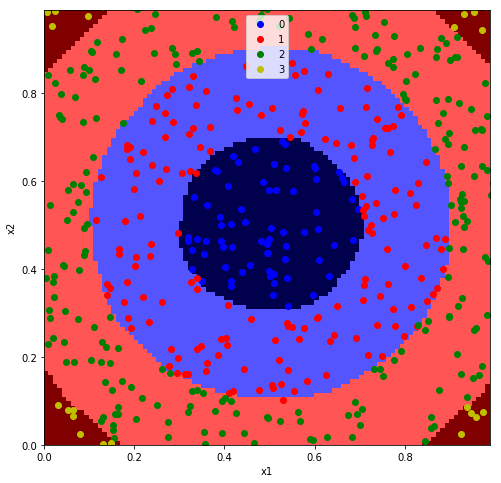

<Figure size 432x288 with 0 Axes>

In [32]:
%matplotlib inline
visualize_classifier(model,inputs_test,outputs_test,device,output_classes)

In [33]:
test_report_model(model,testloader,device)

             precision    recall  f1-score   support

          0       0.97      1.00      0.99        69
          1       0.99      0.99      0.99       169
          2       1.00      0.99      1.00       238
          3       1.00      1.00      1.00        24

avg / total       0.99      0.99      0.99       500



(tensor(0.9920), tensor(496.))

In [34]:
loader_dic={"train":trainloader,"valid":validloader,"test":testloader}
#loader_dic={"valid":validloader,"test":testloader}
for i in loader_dic:
    loader=loader_dic[i]
    print(i+" data set")
    test_report_model(model,loader,device)
    print("*"*50)

train data set
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       958
          1       0.99      0.99      0.99      2862
          2       0.99      1.00      1.00      3293
          3       1.00      0.97      0.98       387

avg / total       0.99      0.99      0.99      7500

**************************************************
valid data set
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       270
          1       1.00      1.00      1.00       747
          2       1.00      1.00      1.00       892
          3       1.00      0.99      0.99        91

avg / total       1.00      1.00      1.00      2000

**************************************************
test data set
             precision    recall  f1-score   support

          0       0.97      1.00      0.99        69
          1       0.99      0.99      0.99       169
          2       1.00      0.99      1.00       238